In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import plotly.express as py
import plotly.graph_objects as go

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Dense, MaxPool2D, Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

from keras import backend as K
from tensorflow.keras.utils import img_to_array, load_img, array_to_img
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import VGG19
from keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import accuracy_score

import cv2    

In [55]:
!nvidia-smi

Sat Apr 22 15:54:34 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.68                 Driver Version: 531.68       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2070 S...  WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8               12W /  N/A|    150MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [56]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [57]:
df_list_attr = pd.read_csv('list_attr_celeba.csv')
df_list_attr.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [58]:
 # Setting 'image_id' column as Index
df_list_attr.replace(to_replace = -1, value = 0,inplace = True ) # Replacing '-1' values for '0', indicating the absence of attributes in the image
df_list_attr.head(10) 

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
5,000006.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,1,1,0,1,0,0,1
6,000007.jpg,1,0,1,1,0,0,1,1,1,...,0,0,1,0,0,0,0,0,0,1
7,000008.jpg,1,1,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
8,000009.jpg,0,1,1,0,0,1,1,0,0,...,0,1,0,0,1,0,1,0,0,1
9,000010.jpg,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1


In [59]:
df_list_attr.corr() # to see how our features are correlated.

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
5_o_Clock_Shadow,1.000000,-0.158587,-0.062415,0.168488,0.005584,-0.089243,-0.043699,0.152010,1.006038e-01,-0.132686,...,0.259370,-0.067777,0.052260,-0.124250,-0.161911,0.033997,-0.333921,-0.116239,0.097899,0.014869
Arched_Eyebrows,-0.158587,1.000000,0.250599,-0.091947,-0.069524,-0.027775,0.243400,-0.084025,-9.959764e-04,0.127009,...,-0.116001,0.093834,-0.054486,0.200835,0.294779,-0.099980,0.460409,0.220184,-0.132821,0.146798
Attractive,-0.062415,0.250599,1.000000,-0.178464,-0.145826,0.059712,0.062552,-0.277064,4.139890e-03,0.154774,...,-0.100229,0.147845,0.041550,0.214992,0.124349,-0.138636,0.480104,0.068738,-0.156420,0.387735
Bags_Under_Eyes,0.168488,-0.091947,-0.178464,1.000000,0.116215,-0.057568,-0.005982,0.361604,2.667485e-03,-0.106879,...,0.100411,0.112759,0.024208,-0.127128,-0.096969,-0.005726,-0.284052,-0.052964,0.196980,-0.230759
Bald,0.005584,-0.069524,-0.145826,0.116215,1.000000,-0.064044,-0.003577,0.180148,-8.036419e-02,-0.063056,...,0.058599,0.009402,-0.071920,-0.103482,-0.061211,-0.030625,-0.142852,-0.050445,0.176501,-0.196253
Bangs,-0.089243,-0.027775,0.059712,-0.057568,-0.064044,1.000000,0.034876,-0.069395,-3.355778e-02,0.098854,...,-0.073341,0.052469,0.020034,0.068166,0.058203,-0.079939,0.163378,0.114454,-0.092919,0.017695
Big_Lips,-0.043699,0.243400,0.062552,-0.005982,-0.003577,0.034876,1.000000,0.076814,6.719131e-02,0.023674,...,-0.039739,0.012885,-0.037144,0.120190,0.126523,-0.013286,0.195212,0.149892,-0.067770,0.107722
Big_Nose,0.152010,-0.084025,-0.277064,0.361604,0.180148,-0.069395,0.076814,1.000000,8.109064e-02,-0.158323,...,0.131667,0.100888,-0.028837,-0.131843,-0.058029,0.065552,-0.303651,-0.035930,0.205014,-0.284382
Black_Hair,0.100604,-0.000996,0.004140,0.002667,-0.080364,-0.033558,0.067191,0.081091,1.000000e+00,-0.233626,...,0.043231,-0.002533,0.112496,-0.085227,0.002348,-0.103605,-0.066856,-0.042539,0.023184,0.121372
Blond_Hair,-0.132686,0.127009,0.154774,-0.106879,-0.063056,0.098854,0.023674,-0.158323,-2.336262e-01,1.000000,...,-0.096039,0.090209,0.005458,0.128400,0.095005,-0.083373,0.281935,0.143577,-0.106377,0.052402


In [60]:
attr_names = []
attr_names = list(df_list_attr.columns)
del attr_names[0]
print(attr_names)

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


In [61]:
# we make a function to visualize the distribution of each attribute present in a particular image.

def plot_attr(attr_names):
    fig_plot = plt.figure(figsize=(20, 15))
    for i, attr_name in enumerate(attr_names):
        fig_plot.add_subplot(4, 10, i+1)
        col = df_list_attr[attr_name]
        g = sns.barplot(x=col.value_counts().index, y=col.value_counts(normalize=True))
        g.set(ylim=(0, 1))
        plt.yticks([])
    plt.show()

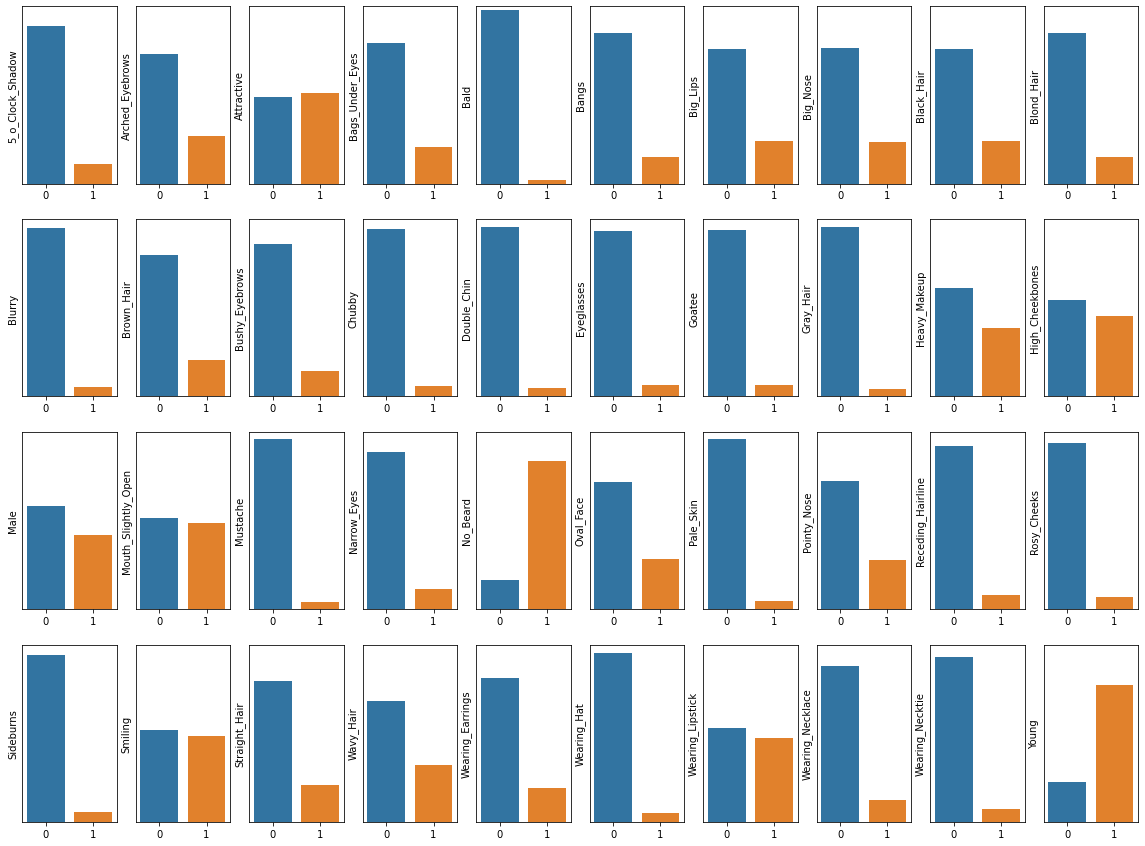

In [62]:
plot_attr(attr_names)

In [63]:
fig = go.Figure()

fig = py.imshow(df_list_attr.corr())
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000)
fig.show()

In [64]:
df_eval_partition = pd.read_csv('list_eval_partition.csv')
df_eval_partition.partition.value_counts()

0    162770
2     19962
1     19867
Name: partition, dtype: int64

In [65]:
df_landmarks_align_celeba = pd.read_csv('list_landmarks_align_celeba.csv')
df_landmarks_align_celeba.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150


In [66]:
df_landmarks_align_celeba.describe()

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
count,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000
mean,69.353867,111.197982,107.644031,111.161600,88.063140,135.102024,71.247459,152.113011,105.586429,152.194660
std,1.717952,1.129284,1.690252,1.169229,6.647733,4.245078,3.168011,1.799343,3.233125,1.752368
min,56.000000,98.000000,90.000000,95.000000,57.000000,93.000000,57.000000,116.000000,82.000000,114.000000
25%,68.000000,111.000000,107.000000,111.000000,84.000000,133.000000,69.000000,151.000000,103.000000,151.000000
50%,69.000000,111.000000,108.000000,111.000000,88.000000,135.000000,72.000000,152.000000,105.000000,152.000000
75%,70.000000,112.000000,109.000000,112.000000,92.000000,138.000000,73.000000,153.000000,108.000000,153.000000
max,88.000000,129.000000,124.000000,122.000000,121.000000,156.000000,90.000000,174.000000,120.000000,173.000000


In [67]:
attr_to_id = {v:i for i, v in enumerate(attr_names)}
attr_to_id

{'5_o_Clock_Shadow': 0,
 'Arched_Eyebrows': 1,
 'Attractive': 2,
 'Bags_Under_Eyes': 3,
 'Bald': 4,
 'Bangs': 5,
 'Big_Lips': 6,
 'Big_Nose': 7,
 'Black_Hair': 8,
 'Blond_Hair': 9,
 'Blurry': 10,
 'Brown_Hair': 11,
 'Bushy_Eyebrows': 12,
 'Chubby': 13,
 'Double_Chin': 14,
 'Eyeglasses': 15,
 'Goatee': 16,
 'Gray_Hair': 17,
 'Heavy_Makeup': 18,
 'High_Cheekbones': 19,
 'Male': 20,
 'Mouth_Slightly_Open': 21,
 'Mustache': 22,
 'Narrow_Eyes': 23,
 'No_Beard': 24,
 'Oval_Face': 25,
 'Pale_Skin': 26,
 'Pointy_Nose': 27,
 'Receding_Hairline': 28,
 'Rosy_Cheeks': 29,
 'Sideburns': 30,
 'Smiling': 31,
 'Straight_Hair': 32,
 'Wavy_Hair': 33,
 'Wearing_Earrings': 34,
 'Wearing_Hat': 35,
 'Wearing_Lipstick': 36,
 'Wearing_Necklace': 37,
 'Wearing_Necktie': 38,
 'Young': 39}

path: 'img_align_celeba/img_align_celeba/000001.jpg'
attributes: ['000001.jpg' 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0
 0 1 1 0 1 0 1 0 0]


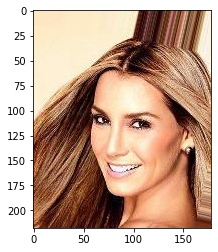

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')
path: 'img_align_celeba/img_align_celeba/000002.jpg'
attributes: ['000002.jpg' 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 0]


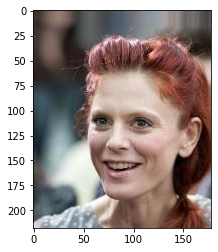

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')
path: 'img_align_celeba/img_align_celeba/000003.jpg'
attributes: ['000003.jpg' 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0
 0 0 0 1 0 0 0 0 0]


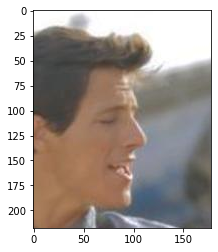

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')
path: 'img_align_celeba/img_align_celeba/000004.jpg'
attributes: ['000004.jpg' 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 1 0 1 0 1 1 0]


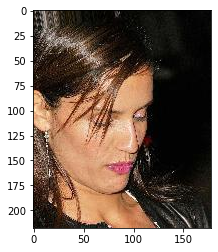

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')
path: 'img_align_celeba/img_align_celeba/000005.jpg'
attributes: ['000005.jpg' 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0
 0 0 0 0 0 0 1 0 0]


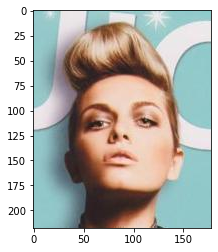

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')
path: 'img_align_celeba/img_align_celeba/000006.jpg'
attributes: ['000006.jpg' 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0
 0 0 0 1 1 0 1 0 0]


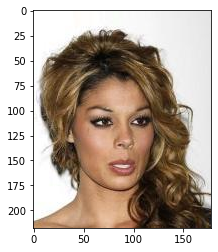

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')
path: 'img_align_celeba/img_align_celeba/000007.jpg'
attributes: ['000007.jpg' 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0
 0 0 1 0 0 0 0 0 0]


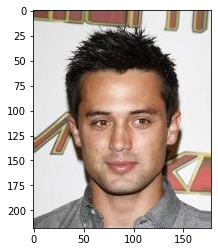

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')
path: 'img_align_celeba/img_align_celeba/000008.jpg'
attributes: ['000008.jpg' 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 0 0 0]


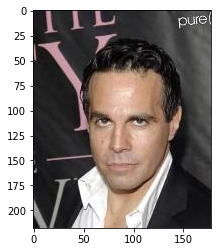

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')
path: 'img_align_celeba/img_align_celeba/000009.jpg'
attributes: ['000009.jpg' 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1
 0 1 0 0 1 0 1 0 0]


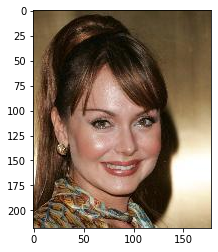

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


In [68]:
for i in range(1,10):
    path = "img_align_celeba/img_align_celeba/"
    
    path = path + "00000"+ str(i) + ".jpg" 
    
    random_sample = df_list_attr.iloc[i-1:i,:]

    print(f"path: '{path}'")
    print(f"attributes: {random_sample.to_numpy()[0, :-1]}")

    # load and convert the image
    pic = cv2.imread(path)
    pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)

    # plot with attributes
    plt.imshow(pic)
    plt.grid(False)
    plt.show()
    
    print(random_sample.columns)

In [69]:
images_path = "img_align_celeba/img_align_celeba/"

In [70]:
df_eval_partition.set_index('image_id', inplace=True)

In [71]:
df_list_attr.set_index('image_id', inplace=True)

In [72]:

df_model = df_eval_partition.join(df_list_attr, how='inner')
df_model.reset_index(inplace=True)

In [73]:
df_model.head()

,image_id,partition,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,0,1,1,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1


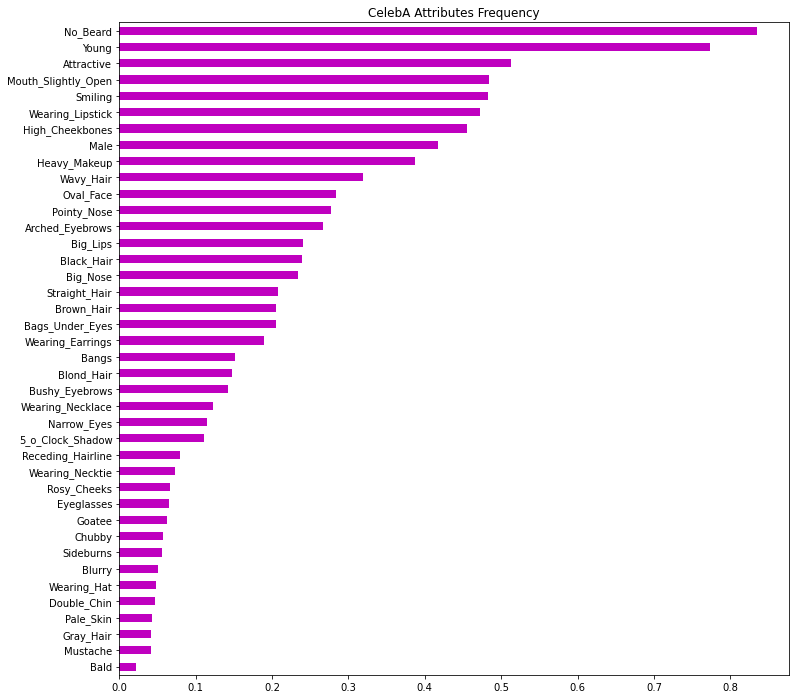

In [74]:

frequencies = df_list_attr.mean(axis=0).sort_values()

_ = frequencies.plot(title='CelebA Attributes Frequency', 
                     kind='barh', 
                     figsize=(12, 12),
                     color='m')

# New

In [75]:
BATCH_SIZE = 128
IMG_WIDTH = 228
IMG_HEIGHT = 228
NUM_EPOCHS = 20

In [76]:
def generator(samples_data, batch_size=BATCH_SIZE, shuffle_data=True,IMG_WIDTH=IMG_WIDTH, IMG_HEIGHT=IMG_HEIGHT):
  
    num_of_samples = len(samples_data)
    while True: 
        samples_data= df_model.sample(frac = 1)
        for offset in range(0, num_of_samples, batch_size):
            batch_of_samples = samples_data.iloc[offset:offset+batch_size, :]
            X_train = []
            y_train = []

            for i in batch_of_samples.index:
              
                img_name = batch_of_samples["image_id"][i]
                label = list(np.array(batch_of_samples[batch_of_samples.index==i].iloc[:, 2:])[0])
                
                img =  cv2.imread('img_align_celeba/img_align_celeba/'+img_name)
                img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
                
                X_train.append(img)
                y_train.append(label)

            X_train = np.array(X_train)
            y_train = np.array(y_train)

           
            yield X_train, y_train

In [77]:
training_data = df_model.loc[df_model["partition"] == 0]
validation_data = df_model.loc[df_model["partition"] == 1]
testing_data = df_model.loc[df_model["partition"] == 2]

In [78]:
training_data.head()

,image_id,partition,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,0,1,1,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1


In [79]:
len(testing_data)

19962

In [80]:
traing_generator = generator(training_data)
validation_generator = generator(validation_data)
testing_generator = generator(testing_data)
     

In [29]:
with tf.device(device_name): 
  VGGmodel = VGG19(weights = None, include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

  vggModel = Model(VGGmodel.inputs, VGGmodel.layers[-1].output)
  for layer in vggModel.layers:
    layer.trainable = False
  
    
  model = Sequential()
  model.add(vggModel)

  model.add(Flatten())

  model.add(Dense(units=512,activation="relu"))
  model.add(Dropout(0.5))

  model.add(Dense(units=40, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.001)))

  model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics="binary_accuracy")

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                20520     
Total params: 32,890,472
Trainable params: 12,866,088
Non-trainable params: 20,024,384
_________________________________________________________________


In [29]:
early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_binary_accuracy", # metrics to monitor
        patience=3, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )

In [30]:
history = model.fit(traing_generator, validation_data = validation_generator, steps_per_epoch= training_data.shape[0]//BATCH_SIZE//10, 
                    validation_steps = validation_data.shape[0] // BATCH_SIZE, epochs= NUM_EPOCHS, callbacks=early_stopping, verbose=1)

Epoch 1/20
127/127 [==============================] - 504s 4s/step - loss: 0.4843 - binary_accuracy: 0.8012 - val_loss: 0.4214 - val_binary_accuracy: 0.8236
Epoch 2/20
127/127 [==============================] - 491s 4s/step - loss: 0.4171 - binary_accuracy: 0.8246 - val_loss: 0.3934 - val_binary_accuracy: 0.8314
Epoch 3/20
127/127 [==============================] - 330s 3s/step - loss: 0.4034 - binary_accuracy: 0.8287 - val_loss: 0.3869 - val_binary_accuracy: 0.8337
Epoch 4/20
127/127 [==============================] - 158s 1s/step - loss: 0.3919 - binary_accuracy: 0.8330 - val_loss: 0.3760 - val_binary_accuracy: 0.8387
Epoch 5/20
127/127 [==============================] - 158s 1s/step - loss: 0.3864 - binary_accuracy: 0.8351 - val_loss: 0.3695 - val_binary_accuracy: 0.8415
Epoch 6/20
127/127 [==============================] - 158s 1s/step - loss: 0.3814 - binary_accuracy: 0.8373 - val_loss: 0.3689 - val_binary_accuracy: 0.8420
Epoch 7/20
127/127 [==============================] - 158s

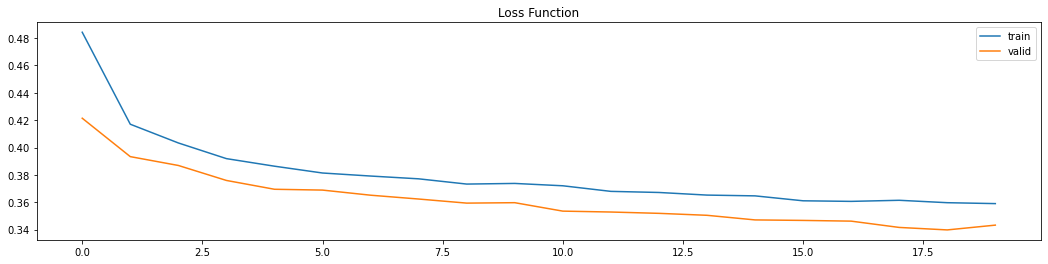

In [31]:

# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

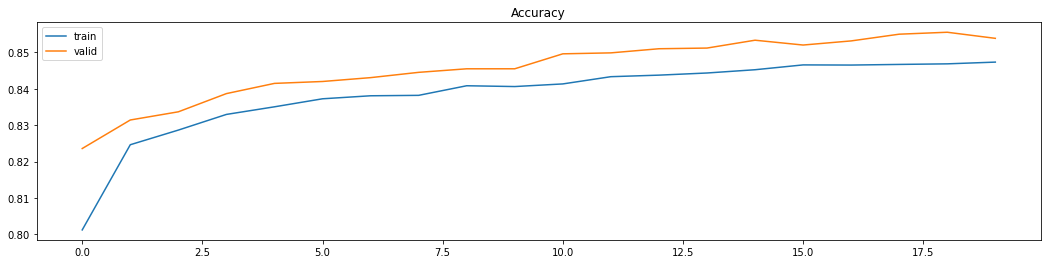

In [32]:

# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(history.history['binary_accuracy'], label = 'train')
plt.plot(history.history['val_binary_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()
     

In [26]:
from sklearn.metrics import accuracy_score

In [34]:
def get_results(testing_data, testing_generator, BATCH_SIZE):
  prediction_list = []
  real_values = []
  for i in range(len(testing_data)//BATCH_SIZE):
    images, labels = next(testing_generator)
    
    # for img, lab in zip(images, labels):
    for pred, true in zip(model.predict(images), labels):
      prediction_list.append(pred)
      real_values.append(true)
  ##############################
  prediction_list = pd.DataFrame(prediction_list)
  prediction_list.columns = list(df_model.head().columns)[2:]
  real_values = pd.DataFrame(real_values)
  real_values.columns = list(df_model.head().columns)[2:]

  for col in prediction_list.columns:
    for index in range(len(prediction_list)):
        if prediction_list[col][index] >= 0.5:
          prediction_list[col][index] = int(1)
        else:
          prediction_list[col][index] = int(0)
  prediction_list = prediction_list.astype(int)

  accuracies = {}
  for col in prediction_list.columns:
    y_true = list(real_values[col])
    y_pred = list(prediction_list[col])
    acc = accuracy_score(y_true, y_pred)
    accuracies[col] = acc
    print("accuracy of "+col+" is : "+str(acc))
  print("**** OVERALL ACCURACY: ", sum(list(accuracies.values()))/len(list(accuracies.values())))

In [35]:
get_results(testing_data, testing_generator, BATCH_SIZE)

accuracy of 5_o_Clock_Shadow is : 0.8911290322580645
accuracy of Arched_Eyebrows is : 0.7381048387096775
accuracy of Attractive is : 0.7232862903225806
accuracy of Bags_Under_Eyes is : 0.7954133064516129
accuracy of Bald is : 0.9774697580645161
accuracy of Bangs is : 0.8712701612903225
accuracy of Big_Lips is : 0.7575100806451613
accuracy of Big_Nose is : 0.7743951612903226
accuracy of Black_Hair is : 0.7951108870967742
accuracy of Blond_Hair is : 0.9115927419354839
accuracy of Blurry is : 0.9491935483870968
accuracy of Brown_Hair is : 0.7968245967741936
accuracy of Bushy_Eyebrows is : 0.8574596774193548
accuracy of Chubby is : 0.9432963709677419
accuracy of Double_Chin is : 0.9552923387096774
accuracy of Eyeglasses is : 0.936945564516129
accuracy of Goatee is : 0.9393649193548387
accuracy of Gray_Hair is : 0.9611391129032258
accuracy of Heavy_Makeup is : 0.8117943548387097
accuracy of High_Cheekbones is : 0.7521169354838709
accuracy of Male is : 0.8602822580645161
accuracy of Mouth_Sl

In [37]:
start = "\033[1m"
end = "\033[0;0m"

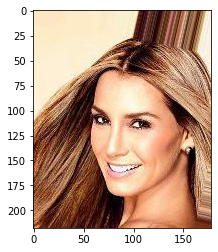

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 1 Predicted: 0
Attractive True: 1 Predicted: 0
Bags_Under_Eyes True: 0 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 0 Predicted: 0
Big_Nose True: 0 Predicted: 0
Black_Hair True: 0 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 1 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 1 Predicted: 0
High_Cheekbones True: 1 Predicted: 0
Male True: 0 Predicted: 0
Mouth_Slightly_Open True: 1 Predicted: 0
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 0
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 1 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

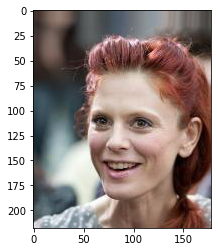

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 0 Predicted: 0
Attractive True: 0 Predicted: 0
Bags_Under_Eyes True: 1 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 0 Predicted: 0
Big_Nose True: 1 Predicted: 0
Black_Hair True: 0 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 1 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 0 Predicted: 0
High_Cheekbones True: 1 Predicted: 0
Male True: 0 Predicted: 1
Mouth_Slightly_Open True: 1 Predicted: 0
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 0
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 0 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

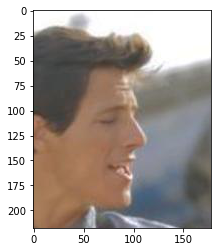

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 0 Predicted: 0
Attractive True: 0 Predicted: 0
Bags_Under_Eyes True: 0 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 1 Predicted: 0
Big_Nose True: 0 Predicted: 0
Black_Hair True: 0 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 1 Predicted: 0
Brown_Hair True: 0 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 0 Predicted: 0
High_Cheekbones True: 0 Predicted: 0
Male True: 1 Predicted: 0
Mouth_Slightly_Open True: 0 Predicted: 0
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 1 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 0
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 1 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

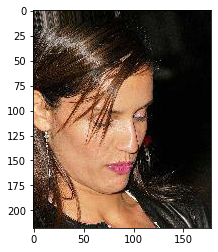

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 0 Predicted: 0
Attractive True: 1 Predicted: 0
Bags_Under_Eyes True: 0 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 0 Predicted: 0
Big_Nose True: 0 Predicted: 0
Black_Hair True: 0 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 0 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 0 Predicted: 0
High_Cheekbones True: 0 Predicted: 0
Male True: 0 Predicted: 1
Mouth_Slightly_Open True: 0 Predicted: 0
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 0
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 1 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

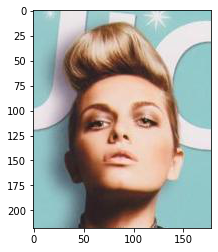

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 1 Predicted: 0
Attractive True: 1 Predicted: 1
Bags_Under_Eyes True: 0 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 1 Predicted: 0
Big_Nose True: 0 Predicted: 0
Black_Hair True: 0 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 0 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 1 Predicted: 0
High_Cheekbones True: 0 Predicted: 0
Male True: 0 Predicted: 0
Mouth_Slightly_Open True: 0 Predicted: 0
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 1 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 0
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 1 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

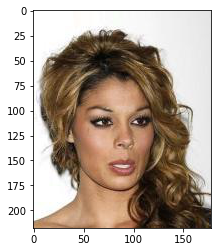

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 1 Predicted: 0
Attractive True: 1 Predicted: 1
Bags_Under_Eyes True: 0 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 1 Predicted: 0
Big_Nose True: 0 Predicted: 0
Black_Hair True: 0 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 1 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 1 Predicted: 0
High_Cheekbones True: 0 Predicted: 0
Male True: 0 Predicted: 0
Mouth_Slightly_Open True: 1 Predicted: 0
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 0
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 0 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

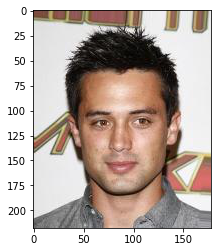

5_o_Clock_Shadow True: 1 Predicted: 0
Arched_Eyebrows True: 0 Predicted: 0
Attractive True: 1 Predicted: 1
Bags_Under_Eyes True: 1 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 1 Predicted: 0
Big_Nose True: 1 Predicted: 0
Black_Hair True: 1 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 0 Predicted: 0
Bushy_Eyebrows True: 1 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 0 Predicted: 0
High_Cheekbones True: 0 Predicted: 0
Male True: 1 Predicted: 1
Mouth_Slightly_Open True: 0 Predicted: 0
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 0
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 1 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

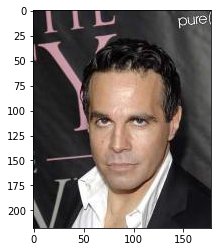

5_o_Clock_Shadow True: 1 Predicted: 0
Arched_Eyebrows True: 1 Predicted: 0
Attractive True: 0 Predicted: 0
Bags_Under_Eyes True: 1 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 1 Predicted: 0
Big_Nose True: 0 Predicted: 0
Black_Hair True: 1 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 0 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 0 Predicted: 0
High_Cheekbones True: 0 Predicted: 0
Male True: 1 Predicted: 1
Mouth_Slightly_Open True: 0 Predicted: 0
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 0
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 1 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

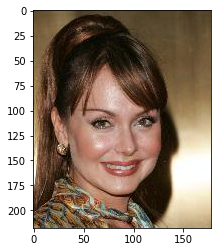

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 1 Predicted: 0
Attractive True: 1 Predicted: 0
Bags_Under_Eyes True: 0 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 1 Predicted: 0
Big_Lips True: 1 Predicted: 0
Big_Nose True: 0 Predicted: 0
Black_Hair True: 0 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 0 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 1 Predicted: 0
High_Cheekbones True: 1 Predicted: 0
Male True: 0 Predicted: 1
Mouth_Slightly_Open True: 1 Predicted: 0
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 1 Predicted: 0
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 1 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 1 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

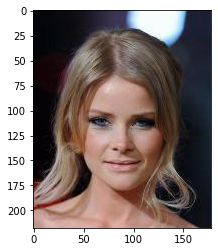

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 0 Predicted: 0
Attractive True: 1 Predicted: 0
Bags_Under_Eyes True: 0 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 0 Predicted: 0
Big_Nose True: 0 Predicted: 0
Black_Hair True: 0 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 0 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 1 Predicted: 0
High_Cheekbones True: 1 Predicted: 0
Male True: 0 Predicted: 0
Mouth_Slightly_Open True: 0 Predicted: 0
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 0
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 0 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

In [37]:
for img_index in range(10):
  original_img = load_img(images_path + df_model["image_id"][img_index])
  real_values = []
  for col in df_model.columns[2:]:
    real_values.append(df_model[col][img_index])
  img = img_to_array(original_img)
  img = cv2.resize(img,(228,228))
  predictions = model.predict(np.array([img]))
  predictions = list(predictions[0])
  plt.imshow(original_img)
  plt.show()

  for true, pred , col in zip(real_values, predictions, df_model.columns[2:]):
    pred = 1 if pred >=0.5 else 0
    if pred==true:
      print("\033[1;32m"+start+col+" True: "+str(true)+ " Predicted: "+str(pred)+end)
    else:
      print("\033[1;31m"+start+col+" True: "+str(true)+ " Predicted: "+str(pred)+end)

In [27]:
with tf.device(device_name): 
  VGGmodel_1 = VGG19(weights = None, include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

  vggModel_1 = Model(VGGmodel_1.inputs, VGGmodel_1.layers[-1].output)
  for layer in vggModel_1.layers[:18]:
    layer.trainable = False
  
    
  model_1 = Sequential()
  model_1.add(vggModel_1)

  model_1.add(Flatten())

  model_1.add(Dense(units=512,activation="relu"))
  model_1.add(Dropout(0.2))

  model_1.add(Dense(units=40, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.001)))

  model_1.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics="binary_accuracy")

In [28]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                20520     
Total params: 32,890,472
Trainable params: 19,945,512
Non-trainable params: 12,944,960
_________________________________________________________________


In [29]:
early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_binary_accuracy", # metrics to monitor
        patience=3, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )

In [30]:
history_1 = model_1.fit(traing_generator, validation_data = validation_generator, steps_per_epoch= training_data.shape[0]//BATCH_SIZE//10, 
                    validation_steps = validation_data.shape[0] // BATCH_SIZE, epochs= NUM_EPOCHS, callbacks=early_stopping, verbose=1)

Epoch 1/20
127/127 [==============================] - 191s 1s/step - loss: 0.5092 - binary_accuracy: 0.7985 - val_loss: 0.4509 - val_binary_accuracy: 0.8118
Epoch 2/20
127/127 [==============================] - 163s 1s/step - loss: 0.4220 - binary_accuracy: 0.8255 - val_loss: 0.3889 - val_binary_accuracy: 0.8395
Epoch 3/20
127/127 [==============================] - 163s 1s/step - loss: 0.3854 - binary_accuracy: 0.8405 - val_loss: 0.3649 - val_binary_accuracy: 0.8488
Epoch 4/20
127/127 [==============================] - 163s 1s/step - loss: 0.3629 - binary_accuracy: 0.8487 - val_loss: 0.3456 - val_binary_accuracy: 0.8554
Epoch 5/20
127/127 [==============================] - 163s 1s/step - loss: 0.3457 - binary_accuracy: 0.8552 - val_loss: 0.3396 - val_binary_accuracy: 0.8567
Epoch 6/20
127/127 [==============================] - 163s 1s/step - loss: 0.3303 - binary_accuracy: 0.8611 - val_loss: 0.3171 - val_binary_accuracy: 0.8664
Epoch 7/20
127/127 [==============================] - 177s

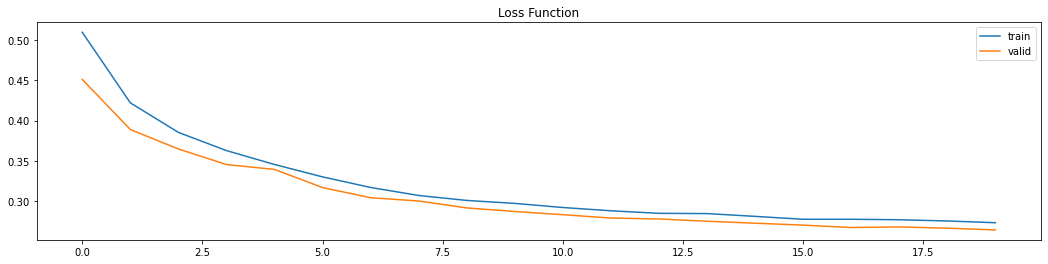

In [31]:

# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(history_1.history['loss'], label = 'train')
plt.plot(history_1.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

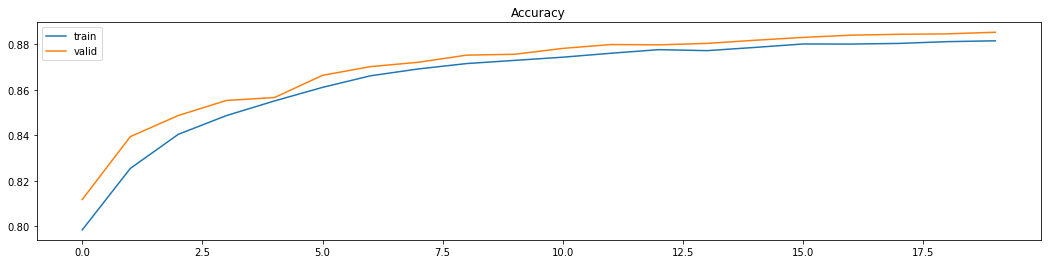

In [32]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(history_1.history['binary_accuracy'], label = 'train')
plt.plot(history_1.history['val_binary_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()
     

In [33]:
def get_results_1(testing_data, testing_generator, BATCH_SIZE):
  prediction_list = []
  real_values = []
  for i in range(len(testing_data)//BATCH_SIZE):
    images, labels = next(testing_generator)
    
    # for img, lab in zip(images, labels):
    for pred, true in zip(model_1.predict(images), labels):
      prediction_list.append(pred)
      real_values.append(true)
  ##############################
  prediction_list = pd.DataFrame(prediction_list)
  prediction_list.columns = list(df_model.head().columns)[2:]
  real_values = pd.DataFrame(real_values)
  real_values.columns = list(df_model.head().columns)[2:]

  for col in prediction_list.columns:
    for index in range(len(prediction_list)):
        if prediction_list[col][index] >= 0.5:
          prediction_list[col][index] = int(1)
        else:
          prediction_list[col][index] = int(0)
  prediction_list = prediction_list.astype(int)

  accuracies = {}
  for col in prediction_list.columns:
    y_true = list(real_values[col])
    y_pred = list(prediction_list[col])
    acc = accuracy_score(y_true, y_pred)
    accuracies[col] = acc
    print("accuracy of "+col+" is : "+str(acc))
  print("**** OVERALL ACCURACY: ", sum(list(accuracies.values()))/len(list(accuracies.values())))

In [34]:
get_results_1(testing_data, testing_generator, BATCH_SIZE)

accuracy of 5_o_Clock_Shadow is : 0.8993951612903226
accuracy of Arched_Eyebrows is : 0.7849798387096775
accuracy of Attractive is : 0.7784274193548387
accuracy of Bags_Under_Eyes is : 0.8123991935483871
accuracy of Bald is : 0.9789314516129032
accuracy of Bangs is : 0.9321572580645161
accuracy of Big_Lips is : 0.7746975806451613
accuracy of Big_Nose is : 0.8104838709677419
accuracy of Black_Hair is : 0.8462197580645161
accuracy of Blond_Hair is : 0.9407258064516129
accuracy of Blurry is : 0.9507560483870968
accuracy of Brown_Hair is : 0.840625
accuracy of Bushy_Eyebrows is : 0.8877520161290322
accuracy of Chubby is : 0.9453629032258064
accuracy of Double_Chin is : 0.9554435483870968
accuracy of Eyeglasses is : 0.9709677419354839
accuracy of Goatee is : 0.9454637096774193
accuracy of Gray_Hair is : 0.9716229838709678
accuracy of Heavy_Makeup is : 0.8829637096774193
accuracy of High_Cheekbones is : 0.8406754032258065
accuracy of Male is : 0.9430947580645161
accuracy of Mouth_Slightly_Op

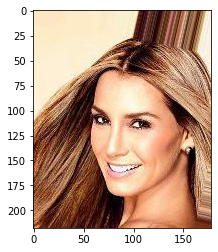

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 1 Predicted: 0
Attractive True: 1 Predicted: 0
Bags_Under_Eyes True: 0 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 0 Predicted: 0
Big_Nose True: 0 Predicted: 0
Black_Hair True: 0 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 1 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 1 Predicted: 0
High_Cheekbones True: 1 Predicted: 0
Male True: 0 Predicted: 0
Mouth_Slightly_Open True: 1 Predicted: 0
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 0
Pale_Skin True: 0 Predicted: 1
Pointy_Nose True: 1 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

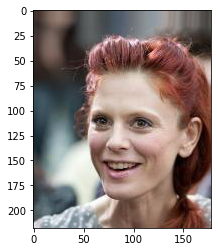

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 0 Predicted: 0
Attractive True: 0 Predicted: 0
Bags_Under_Eyes True: 1 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 0 Predicted: 0
Big_Nose True: 1 Predicted: 0
Black_Hair True: 0 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 1 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 0 Predicted: 0
High_Cheekbones True: 1 Predicted: 0
Male True: 0 Predicted: 1
Mouth_Slightly_Open True: 1 Predicted: 1
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 0
Pale_Skin True: 0 Predicted: 1
Pointy_Nose True: 0 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

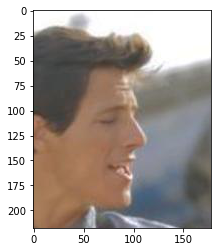

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 0 Predicted: 0
Attractive True: 0 Predicted: 0
Bags_Under_Eyes True: 0 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 1 Predicted: 0
Big_Nose True: 0 Predicted: 0
Black_Hair True: 0 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 1 Predicted: 0
Brown_Hair True: 0 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 0 Predicted: 0
High_Cheekbones True: 0 Predicted: 0
Male True: 1 Predicted: 1
Mouth_Slightly_Open True: 0 Predicted: 0
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 1 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 0
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 1 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

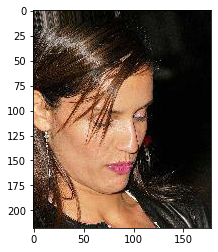

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 0 Predicted: 0
Attractive True: 1 Predicted: 0
Bags_Under_Eyes True: 0 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 0 Predicted: 0
Big_Nose True: 0 Predicted: 0
Black_Hair True: 0 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 0 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 0 Predicted: 0
High_Cheekbones True: 0 Predicted: 0
Male True: 0 Predicted: 1
Mouth_Slightly_Open True: 0 Predicted: 0
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 0
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 1 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

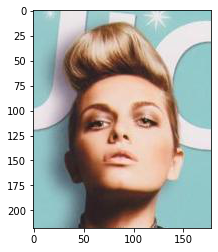

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 1 Predicted: 0
Attractive True: 1 Predicted: 0
Bags_Under_Eyes True: 0 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 1 Predicted: 0
Big_Nose True: 0 Predicted: 0
Black_Hair True: 0 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 0 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 1 Predicted: 0
High_Cheekbones True: 0 Predicted: 0
Male True: 0 Predicted: 0
Mouth_Slightly_Open True: 0 Predicted: 0
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 1 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 0
Pale_Skin True: 0 Predicted: 1
Pointy_Nose True: 1 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

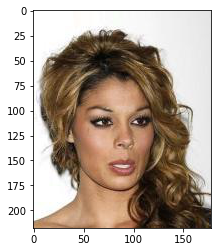

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 1 Predicted: 0
Attractive True: 1 Predicted: 0
Bags_Under_Eyes True: 0 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 1 Predicted: 0
Big_Nose True: 0 Predicted: 0
Black_Hair True: 0 Predicted: 1
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 1 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 1 Predicted: 0
High_Cheekbones True: 0 Predicted: 0
Male True: 0 Predicted: 1
Mouth_Slightly_Open True: 1 Predicted: 0
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 0
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 0 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

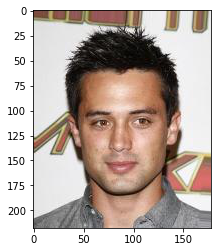

5_o_Clock_Shadow True: 1 Predicted: 0
Arched_Eyebrows True: 0 Predicted: 0
Attractive True: 1 Predicted: 1
Bags_Under_Eyes True: 1 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 1 Predicted: 0
Big_Nose True: 1 Predicted: 0
Black_Hair True: 1 Predicted: 1
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 0 Predicted: 0
Bushy_Eyebrows True: 1 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 0 Predicted: 0
High_Cheekbones True: 0 Predicted: 0
Male True: 1 Predicted: 1
Mouth_Slightly_Open True: 0 Predicted: 0
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 0
Pale_Skin True: 0 Predicted: 1
Pointy_Nose True: 1 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

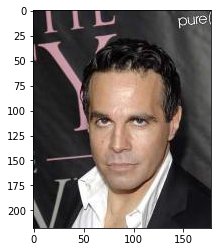

5_o_Clock_Shadow True: 1 Predicted: 0
Arched_Eyebrows True: 1 Predicted: 0
Attractive True: 0 Predicted: 0
Bags_Under_Eyes True: 1 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 1 Predicted: 0
Big_Nose True: 0 Predicted: 0
Black_Hair True: 1 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 0 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 0 Predicted: 0
High_Cheekbones True: 0 Predicted: 0
Male True: 1 Predicted: 1
Mouth_Slightly_Open True: 0 Predicted: 0
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 0
Pale_Skin True: 0 Predicted: 1
Pointy_Nose True: 1 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

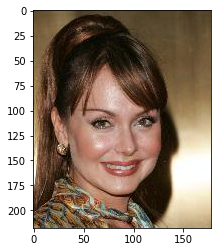

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 1 Predicted: 0
Attractive True: 1 Predicted: 0
Bags_Under_Eyes True: 0 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 1 Predicted: 0
Big_Lips True: 1 Predicted: 0
Big_Nose True: 0 Predicted: 0
Black_Hair True: 0 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 0 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 1 Predicted: 0
High_Cheekbones True: 1 Predicted: 0
Male True: 0 Predicted: 0
Mouth_Slightly_Open True: 1 Predicted: 0
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 1 Predicted: 0
Pale_Skin True: 0 Predicted: 1
Pointy_Nose True: 1 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 1 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

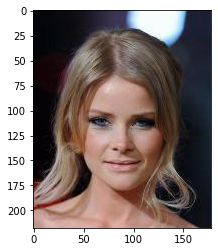

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 0 Predicted: 0
Attractive True: 1 Predicted: 0
Bags_Under_Eyes True: 0 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 0 Predicted: 0
Big_Nose True: 0 Predicted: 0
Black_Hair True: 0 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 0 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 1 Predicted: 0
High_Cheekbones True: 1 Predicted: 0
Male True: 0 Predicted: 1
Mouth_Slightly_Open True: 0 Predicted: 0
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 0
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 0 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

In [38]:
for img_index in range(10):
  original_img = load_img(images_path + df_model["image_id"][img_index])
  real_values = []
  for col in df_model.columns[2:]:
    real_values.append(df_model[col][img_index])
  img = img_to_array(original_img)
  img = cv2.resize(img,(228,228))
  predictions = model_1.predict(np.array([img]))
  predictions = list(predictions[0])
  plt.imshow(original_img)
  plt.show()

  for true, pred , col in zip(real_values, predictions, df_model.columns[2:]):
    pred = 1 if pred >=0.5 else 0
    if pred==true:
      print("\033[1;32m"+start+col+" True: "+str(true)+ " Predicted: "+str(pred)+end)
    else:
      print("\033[1;31m"+start+col+" True: "+str(true)+ " Predicted: "+str(pred)+end)

In [39]:
model_1.save('vgg19_unfreeze.h5')

In [81]:
with tf.device(device_name): 
  inception_model = InceptionV3(weights = 'imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

  inception_model_1 = Model(inception_model.inputs, inception_model.layers[-1].output)
  for layer in inception_model_1.layers:
    layer.trainable = False
  
    
  model_2 = Sequential()
  model_2.add(inception_model_1)

  model_2.add(Flatten())

  model_2.add(Dense(units=512,activation="relu"))
  model_2.add(Dropout(0.2))

  model_2.add(Dense(units=40, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.001)))

  model_2.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics="binary_accuracy")

87924736/87910968 [==============================] - 2s 0us/step


In [82]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 40)                20520     
Total params: 48,038,216
Trainable params: 26,235,432
Non-trainable params: 21,802,784
_________________________________________________________________


In [83]:
early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_binary_accuracy", # metrics to monitor
        patience=3, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )

In [ ]:
history_2 = model_2.fit(traing_generator, validation_data = validation_generator, steps_per_epoch= training_data.shape[0]//BATCH_SIZE//10, 
                    validation_steps = validation_data.shape[0] // BATCH_SIZE, epochs= NUM_EPOCHS, callbacks=early_stopping, verbose=1)

In [27]:
with tf.device(device_name): 
  inception_model_tune = InceptionV3(weights = None, include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

  inception_model_1_tune = Model(inception_model_tune.inputs, inception_model_tune.layers[-1].output)
  for layer in inception_model_1_tune.layers[:249]:
    layer.trainable = False
  
    
  model_3 = Sequential()
  model_3.add(inception_model_1_tune)

  model_3.add(Flatten())

  model_3.add(Dense(units=512,activation="relu"))
  model_3.add(Dropout(0.2))

  model_3.add(Dense(units=40, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.001)))

  model_3.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics="binary_accuracy")

In [28]:
model_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               26214912  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                20520     
Total params: 48,038,216
Trainable params: 37,350,312
Non-trainable params: 10,687,904
_________________________________________________________________


In [33]:
early_stopping_3 = keras.callbacks.EarlyStopping(
        monitor="val_binary_accuracy", # metrics to monitor
        patience=5, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )

In [30]:
history_3 = model_3.fit(traing_generator, validation_data = validation_generator, steps_per_epoch= training_data.shape[0]//BATCH_SIZE//10, 
                    validation_steps = validation_data.shape[0] // BATCH_SIZE, epochs= NUM_EPOCHS, callbacks=early_stopping_3, verbose=1)

Epoch 1/20
127/127 [==============================] - 94s 649ms/step - loss: 0.7077 - binary_accuracy: 0.7841 - val_loss: 0.4676 - val_binary_accuracy: 0.8119
Epoch 2/20
127/127 [==============================] - 80s 630ms/step - loss: 0.4357 - binary_accuracy: 0.8270 - val_loss: 0.4296 - val_binary_accuracy: 0.8206
Epoch 3/20
127/127 [==============================] - 80s 630ms/step - loss: 0.4006 - binary_accuracy: 0.8391 - val_loss: 0.4227 - val_binary_accuracy: 0.8189
Epoch 4/20
127/127 [==============================] - 79s 628ms/step - loss: 0.3793 - binary_accuracy: 0.8465 - val_loss: 0.8886 - val_binary_accuracy: 0.7672
Epoch 5/20
127/127 [==============================] - 79s 627ms/step - loss: 0.3656 - binary_accuracy: 0.8505 - val_loss: 0.4373 - val_binary_accuracy: 0.8208
Epoch 6/20
127/127 [==============================] - 81s 639ms/step - loss: 0.3552 - binary_accuracy: 0.8536 - val_loss: 0.4107 - val_binary_accuracy: 0.8220
Epoch 7/20
127/127 [==========================

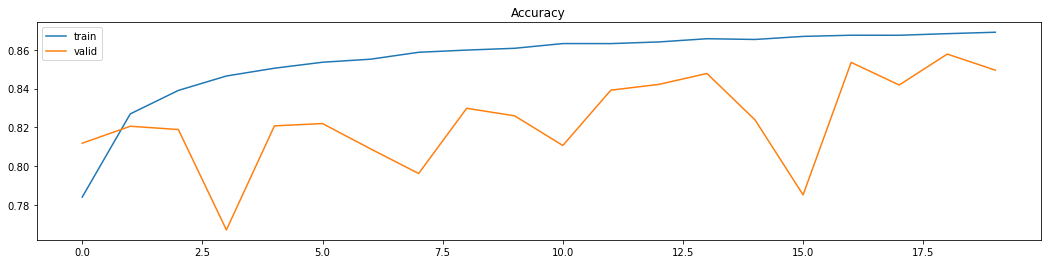

In [42]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(history_3.history['binary_accuracy'], label = 'train')
plt.plot(history_3.history['val_binary_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()
     

In [41]:
def get_results_3(testing_data, testing_generator, BATCH_SIZE):
  prediction_list = []
  real_values = []
  for i in range(len(testing_data)//BATCH_SIZE):
    images, labels = next(testing_generator)
    
    # for img, lab in zip(images, labels):
    for pred, true in zip(model_3.predict(images), labels):
      prediction_list.append(pred)
      real_values.append(true)
  ##############################
  prediction_list = pd.DataFrame(prediction_list)
  prediction_list.columns = list(df_model.head().columns)[2:]
  real_values = pd.DataFrame(real_values)
  real_values.columns = list(df_model.head().columns)[2:]

  for col in prediction_list.columns:
    for index in range(len(prediction_list)):
        if prediction_list[col][index] >= 0.5:
          prediction_list[col][index] = int(1)
        else:
          prediction_list[col][index] = int(0)
  prediction_list = prediction_list.astype(int)

  accuracies = {}
  for col in prediction_list.columns:
    y_true = list(real_values[col])
    y_pred = list(prediction_list[col])
    acc = accuracy_score(y_true, y_pred)
    accuracies[col] = acc
    print("accuracy of "+col+" is : "+str(acc))
  print("**** OVERALL ACCURACY: ", sum(list(accuracies.values()))/len(list(accuracies.values())))

In [45]:
get_results_3(testing_data, testing_generator, BATCH_SIZE)

accuracy of 5_o_Clock_Shadow is : 0.8901209677419355
accuracy of Arched_Eyebrows is : 0.7395665322580646
accuracy of Attractive is : 0.7322076612903226
accuracy of Bags_Under_Eyes is : 0.7943548387096774
accuracy of Bald is : 0.9781754032258064
accuracy of Bangs is : 0.8760584677419355
accuracy of Big_Lips is : 0.7528225806451613
accuracy of Big_Nose is : 0.7666834677419355
accuracy of Black_Hair is : 0.7922883064516129
accuracy of Blond_Hair is : 0.8597278225806452
accuracy of Blurry is : 0.9464213709677419
accuracy of Brown_Hair is : 0.7975302419354838
accuracy of Bushy_Eyebrows is : 0.858366935483871
accuracy of Chubby is : 0.9418850806451613
accuracy of Double_Chin is : 0.9545362903225807
accuracy of Eyeglasses is : 0.9357358870967742
accuracy of Goatee is : 0.9375
accuracy of Gray_Hair is : 0.9576108870967742
accuracy of Heavy_Makeup is : 0.8247983870967742
accuracy of High_Cheekbones is : 0.7538810483870968
accuracy of Male is : 0.7211693548387097
accuracy of Mouth_Slightly_Open 